# 🚲 Bike Sharing Demand

https://www.kaggle.com/competitions/bike-sharing-demand/submissions   
**제출 형식**: [datetime, count]   
**문제**: 다양한 피처들에 따른 자전거의 대여량을 예측   
**문제 풀이 방식**: 회귀


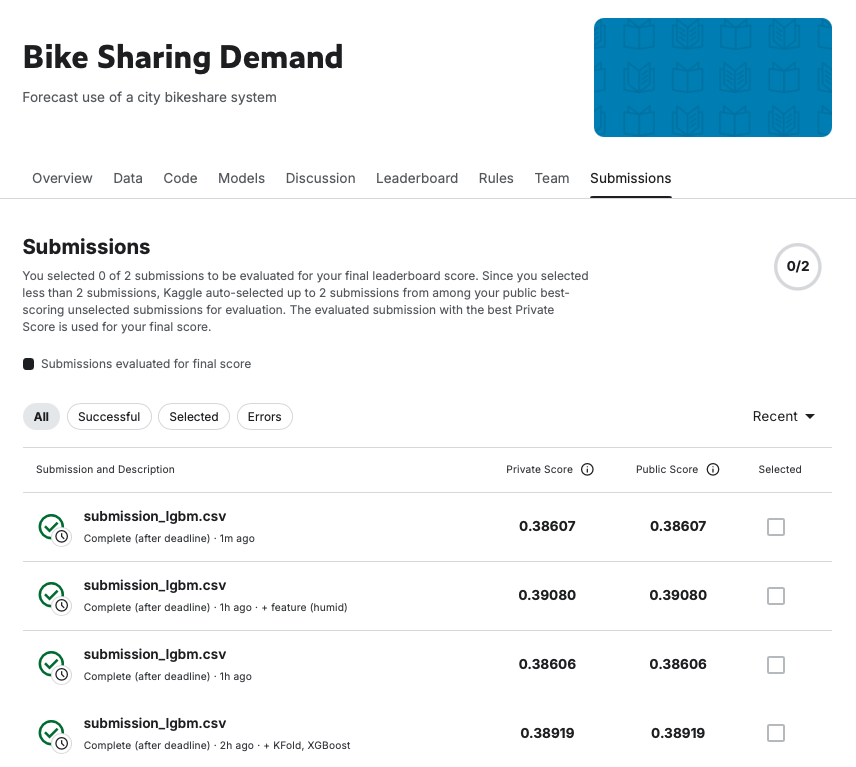

In [ ]:
import IPython.display as ipd

img = '/Users/kimdohyeon/Desktop/2025/kaggle_Bike/Sub.png'
ipd.Image(img)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"  # Mac 기본 한글 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
datetime_col = test_df['datetime'].copy()
print(train_df.shape)
train_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### 📌 타입 변경

train 데이터의 정보를 확인한 결과, 총 12개의 컬럼이 있었고 datetime을 제외한 나머지 컬럼은 숫자형 타입이였다.   
학습을 위해 datetime의 타입을 변경해 준다.   

-> 여기서 `weekday` 컬럼까지 추가해준다 ! (주말과 깊은 연관성이 있지 않을까? 라는 생각 ...)

In [4]:
print(type(train_df['datetime']))
print(type(test_df['datetime']))


train_df['datetime'] = train_df.datetime.apply(pd.to_datetime)
test_df['datetime'] = test_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간을 추출
# 추출 이후 datetime 컬럼 삭제
train_df['year'] = train_df.datetime.apply(lambda x : x.year)
train_df['month'] = train_df.datetime.apply(lambda x : x.month)
train_df['day'] = train_df.datetime.apply(lambda x : x.day)
train_df['hour'] = train_df.datetime.apply(lambda x: x.hour)
train_df['weekday'] = train_df.datetime.dt.weekday
train_df.drop('datetime', axis=1, inplace=True)

test_df['year'] = test_df.datetime.apply(lambda x : x.year)
test_df['month'] = test_df.datetime.apply(lambda x : x.month)
test_df['day'] = test_df.datetime.apply(lambda x : x.day)
test_df['hour'] = test_df.datetime.apply(lambda x: x.hour)
test_df['weekday'] = test_df.datetime.dt.weekday
test_df.drop('datetime', axis=1, inplace=True)

print(train_df.head())
print(test_df.head())

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   casual  registered  count  year  month  day  hour  weekday  
0       3          13     16  2011      1    1     0        5  
1       8          32     40  2011      1    1     1        5  
2       5          27     32  2011      1    1     2        5  
3       3          10     13  2011      1    1     3        5  
4       0           1      1  2011      1    1     4        5  
   season  holiday  workingday  weather   temp   atemp  humidity  windspeed

컬럼을 동일하게 해주기 위헤    
`train_df`에만 있는 `casual`, `registered` 컬럼을 제거해준다.

In [5]:
train_df.drop(['casual', 'registered'], axis=1, inplace=True)

season 
- 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  

holiday 
- 그 날이 휴일로 간주되는지 여부   

workingday 
- 그 날이 주말도 휴일도 아닌지 여부   

weather 
- 1: 맑음, 구름 많음, 흐림 부분, 흐림   
- 2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 구름 몇 개, 안개   
- 3: 가벼운 눈, 약한 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름   
- 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개   

temp 
- 섭씨 온도   

atemp 
- 체감 온도

humidity 
- 상대 습도   

windspeed 
- 풍속   

count 
- 총 대여 수

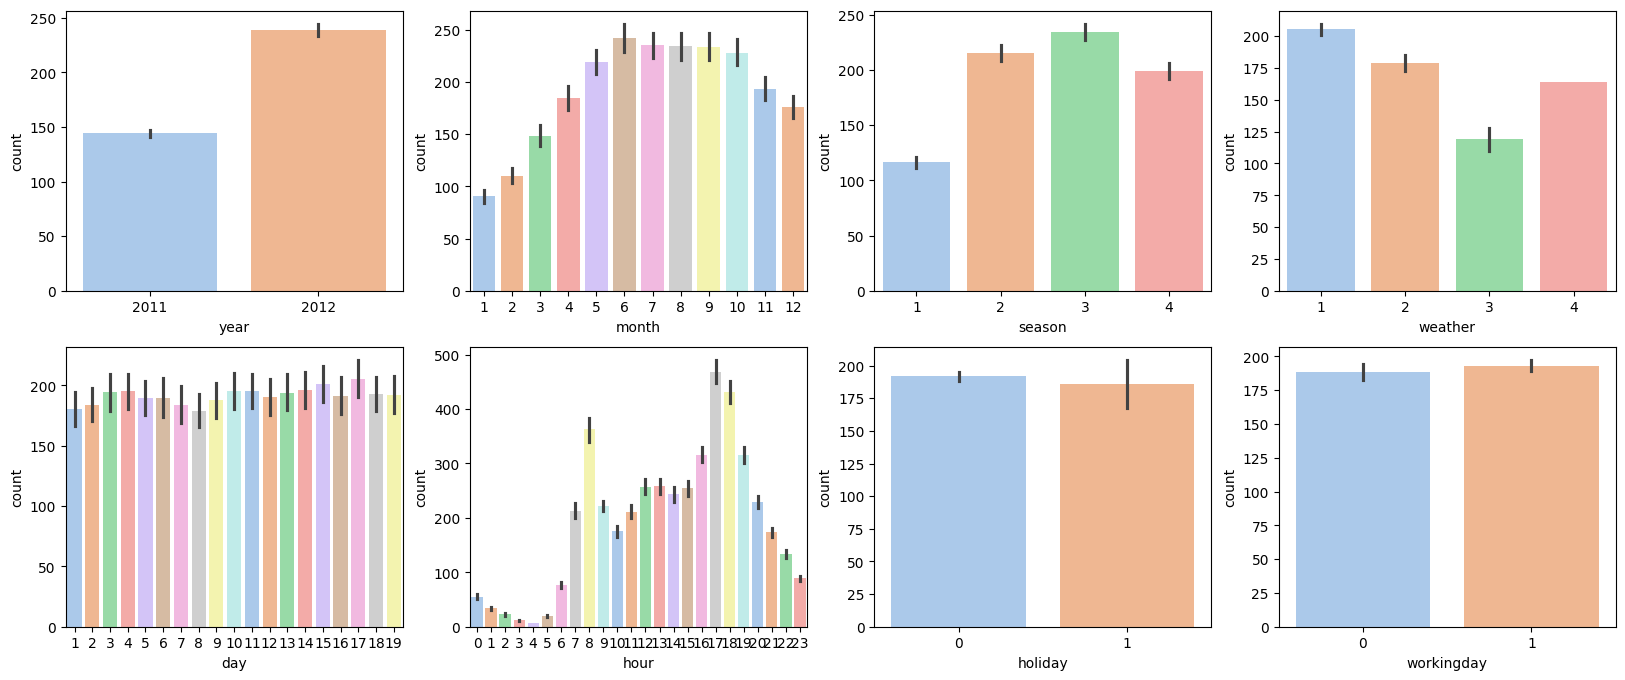

In [6]:
fig, axs = plt.subplots(figsize=(20, 8), ncols=4, nrows=2)
features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
for i, feature in enumerate(features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=train_df, ax=axs[row][col], palette='pastel')

### 📌 요일별 시간대에 따른 대여량

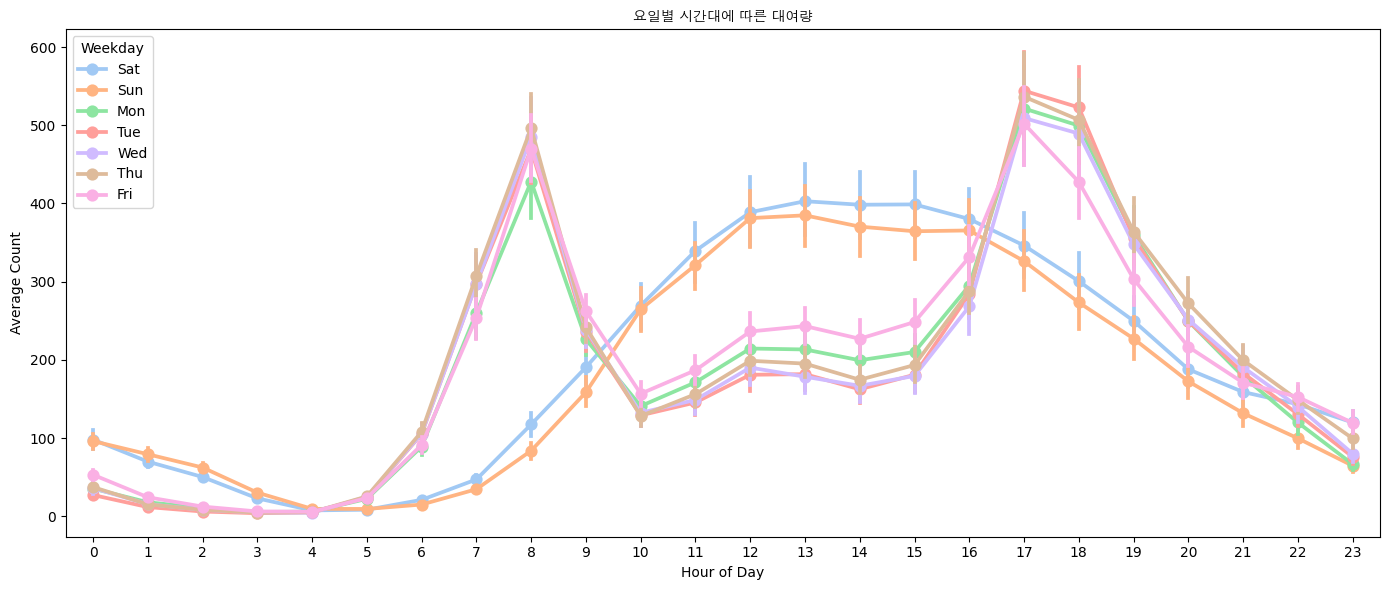

In [ ]:
# 필요한 datetime 컬럼 다시 처리해서 hour, weekday 추출
train_df_plot = pd.read_csv("train.csv")
train_df_plot['datetime'] = pd.to_datetime(train_df_plot['datetime'])

train_df_plot['hour'] = train_df_plot['datetime'].dt.hour
train_df_plot['weekday'] = train_df_plot['datetime'].dt.weekday

# 숫자 요일 → 문자 요일로 변환
weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
train_df_plot['weekday_str'] = train_df_plot['weekday'].map(weekday_map)

# 요일별 시간대(hour)에 따른 평균 대여량 시각화
plt.figure(figsize=(14, 6))
sns.pointplot(x='hour', y='count', hue='weekday_str', data=train_df_plot, palette='pastel')

plt.title('요일별 시간대에 따른 대여량', fontproperties=font_prop)
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.legend(title='Weekday', loc='upper left')

plt.tight_layout()
plt.show()

➡️ 주중에는 출근시간대 (7시~9시)& 퇴근시간대 (17시~19시)가 가장 많이 대여하고   
➡️ 주말에는 낮시간대 (12시~16시)가 가장 많이 대여함   


📍 그렇다면 평일&출근시간대와 주말&낮시간대 피쳐를 새로 생성할 수 있지 않을까?

### 📌 평일: 출근&퇴근 시간대와 주말: 낮시간대 피쳐 생성

In [8]:
# 출근 시간대 (평일 & 7~9시)
train_df['is_rush_hour'] = ((train_df['workingday'] == 1) & (train_df['hour'].isin([7, 8, 9]))).astype(int)
test_df['is_rush_hour'] = ((test_df['workingday'] == 1) & (test_df['hour'].isin([7, 8, 9]))).astype(int)

# 퇴근 시간대 (평일 & 17~19시)
train_df['is_return_hour'] = ((train_df['workingday'] == 1) & (train_df['hour'].isin([17, 18, 19]))).astype(int)
test_df['is_return_hour'] = ((test_df['workingday'] == 1) & (test_df['hour'].isin([17, 18, 19]))).astype(int)

# 주말 낮 시간대 (주말 & 12~16시)
train_df['is_weekend_lunch'] = ((train_df['weekday'].isin([5, 6])) & (train_df['hour'].isin([12, 13, 14, 15 ,16]))).astype(int)
test_df['is_weekend_lunch'] = ((test_df['weekday'].isin([5, 6])) & (test_df['hour'].isin([12, 13, 14, 15, 16]))).astype(int)

### 📌 변수들 간의 상관관계 분석

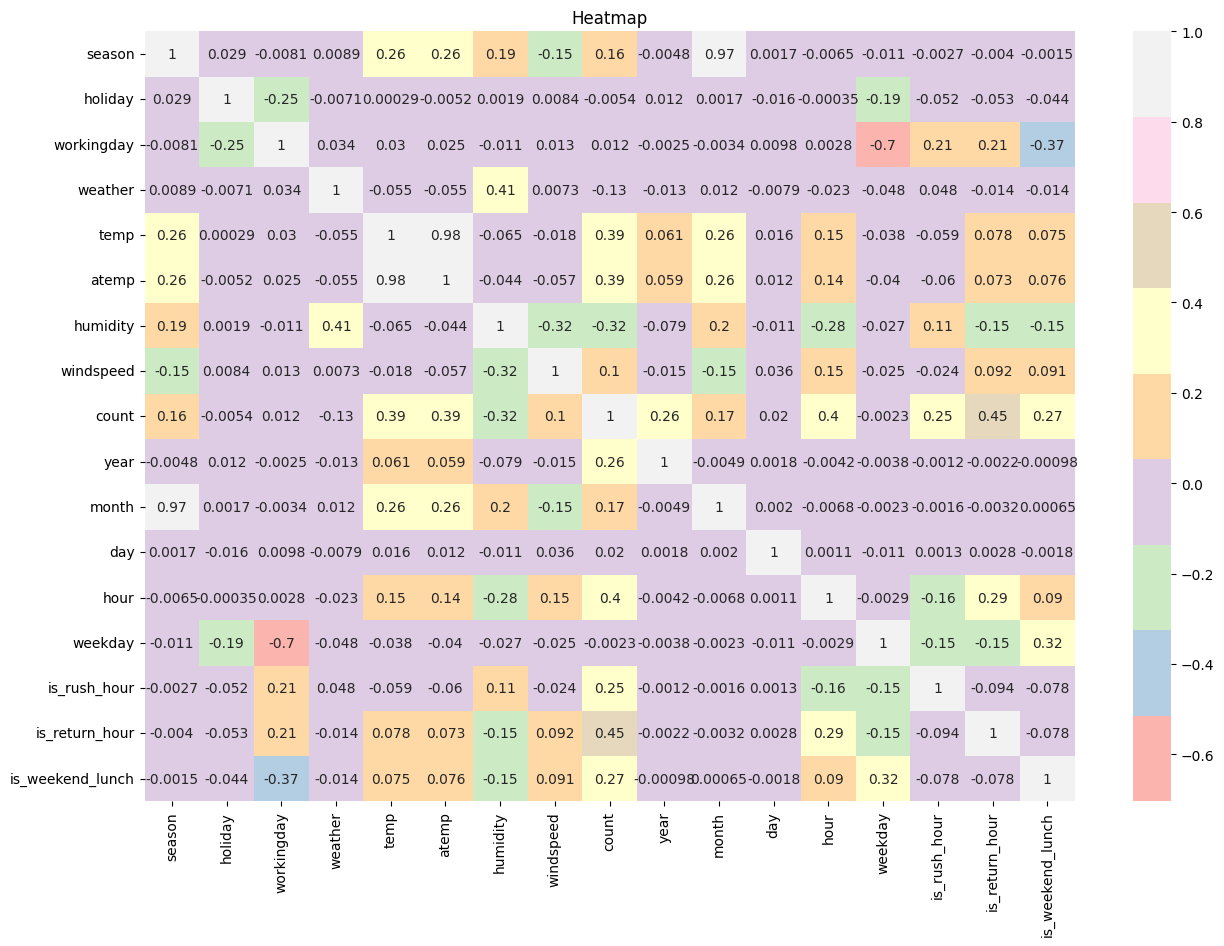

In [9]:
plt.figure(figsize=(15, 10))

sns.heatmap(train_df.corr(), annot=True, cmap='Pastel1')
plt.title("Heatmap")
plt.show()

📍 count와의 상관관계 분석   

양의 상관관계   
- 0.45|is_return_hour⭐️
- 0.4|hour⭐️   
- 0.39|atemp, temp
- 0.27|is_weekend_lunch

---

음의 상관관계   
- -0.32|humidity

📍 추가적인 상관관계 분석   

- month와 season은 0.97의 상관관계로, 거의 같은 값을 가지고 있다 (둘 중 하나만 쓰는 것이 나을 것 같음)   
-> 하지만 밑에 특징 분석하기 위해 지우지는 않겠음 !! (마지막 학습 때 지울 예정)

- temp와 atemp도 0.98의 상관관계로, 거의 같은 값을 가지고 있다   
-> 하지만 동일하게 분석을 위해 지우지는 않겠음 ! (마지막 학습 때 지울 예정)

### 📌 섭씨온도를 기준을 두고 나눈다.   

미국기준   

춥다| 화씨 50도 = 섭씨 10도   
쌀쌀하다| 화씨 60도 = 섭씨 15.6도   
따뜻하다| 화씨 70도 = 섭씨 21.1도   
덥다| 화씨 80도 = 섭씨 26.7도

In [10]:
def label_temp(temp):
    if temp <= 10:
        return 'cold'
    elif temp <= 15.6:
        return 'chill'
    elif temp <= 21.1:
        return 'warm'
    elif temp <= 26.7:
        return 'hot'
    else:
        return 'very hot'
    
train_df['temp_label'] = train_df.temp.apply(lambda x : label_temp(x))
test_df['temp_label'] = test_df.temp.apply(lambda x : label_temp(x))

encoder_temp = OneHotEncoder(sparse_output=False)
# OneHotEncoder는 defalut로 numpy array를 반환하기 때문에 DataFrame으로 변환해주어야 한다. (sparse_output=False)
temp_ohe = encoder_temp.fit_transform(train_df[['temp_label']])
test_temp_ohe = encoder_temp.transform(test_df[['temp_label']])

temp_columns = encoder_temp.get_feature_names_out(['temp_label'])
train_temp_df = pd.DataFrame(temp_ohe, columns=temp_columns, index=train_df.index)
test_temp_df = pd.DataFrame(test_temp_ohe, columns=temp_columns, index=test_df.index)

train_df = pd.concat([train_df, train_temp_df], axis=1)
train_df.drop(['temp'], axis=1, inplace=True)
test_df = pd.concat([test_df, test_temp_df], axis=1)
test_df.drop(['temp'], axis=1, inplace=True)

In [11]:
train_df.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,...,weekday,is_rush_hour,is_return_hour,is_weekend_lunch,temp_label,temp_label_chill,temp_label_cold,temp_label_hot,temp_label_very hot,temp_label_warm
0,1,0,0,1,14.395,81,0.0,16,2011,1,...,5,0,0,0,cold,0.0,1.0,0.0,0.0,0.0
1,1,0,0,1,13.635,80,0.0,40,2011,1,...,5,0,0,0,cold,0.0,1.0,0.0,0.0,0.0
2,1,0,0,1,13.635,80,0.0,32,2011,1,...,5,0,0,0,cold,0.0,1.0,0.0,0.0,0.0
3,1,0,0,1,14.395,75,0.0,13,2011,1,...,5,0,0,0,cold,0.0,1.0,0.0,0.0,0.0
4,1,0,0,1,14.395,75,0.0,1,2011,1,...,5,0,0,0,cold,0.0,1.0,0.0,0.0,0.0


In [12]:
train_df.tail()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,...,weekday,is_rush_hour,is_return_hour,is_weekend_lunch,temp_label,temp_label_chill,temp_label_cold,temp_label_hot,temp_label_very hot,temp_label_warm
10881,4,0,1,1,19.695,50,26.0027,336,2012,12,...,2,0,1,0,chill,1.0,0.0,0.0,0.0,0.0
10882,4,0,1,1,17.425,57,15.0013,241,2012,12,...,2,0,0,0,chill,1.0,0.0,0.0,0.0,0.0
10883,4,0,1,1,15.910,61,15.0013,168,2012,12,...,2,0,0,0,chill,1.0,0.0,0.0,0.0,0.0
10884,4,0,1,1,17.425,61,6.0032,129,2012,12,...,2,0,0,0,chill,1.0,0.0,0.0,0.0,0.0
10885,4,0,1,1,16.665,66,8.9981,88,2012,12,...,2,0,0,0,chill,1.0,0.0,0.0,0.0,0.0


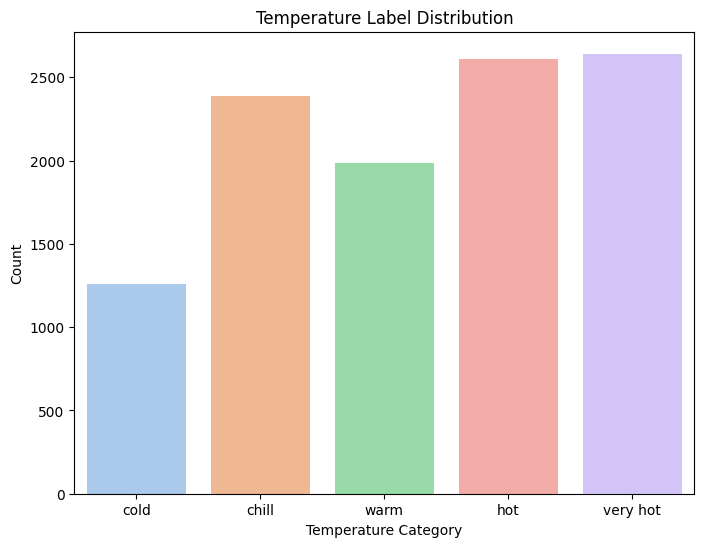

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='temp_label', data=train_df, order=['cold', 'chill', 'warm', 'hot', 'very hot'], palette='pastel')
plt.title("Temperature Label Distribution")
plt.xlabel("Temperature Category")
plt.ylabel("Count")
plt.show()

### 📌 습도를 기준을 두어 나눈다.  
 

위에 plot한 heatmap을 보면 습도(`humidity`)는 대여 횟수(`count`)와 꽤 높은 음의 상관관계를 가지고 있다.   
습도가 올라갈 수록 대여 횟수가 줄어든다는 것을 추측할 수 있는데, 이는 아직 확실한 것이 아니기 때문에 그래프를 그려 확인해보려 한다.


➡️ 오히려 점수가 안 좋아졌다 .. 안 하는 걸로!

In [14]:
#plt.figure(figsize=(10, 5))
#sns.scatterplot(x='humidity', y='count', data=train_df, alpha=0.3, color='pink')
#plt.title("습도에 따른 대여량", fontproperties=font_prop)
#plt.xlabel("습도", fontproperties=font_prop)
#plt.ylabel("대여량", fontproperties=font_prop)
#plt.show()

그래프를 확인해보면 오히려 너무 낮은 습도에서는 대여량이 거의 없다는 사실을 확인할 수 있다.   
그렇기 때문에 다음과 같이 범주화를 할 예정이다.   

매우낮음| 0~20   
낮음| 20~50   
중간| 50~80   
높음| 80~100

In [15]:
#def label_humidity(humidity):
#    if humidity <= 20:
#        return 'very low'
#    elif humidity <= 50:
#        return 'low'
#    elif humidity <= 80:
#        return 'medium'
#    else:
#        return 'high'
    
#train_df['humid_label'] = train_df.humidity.apply(lambda x : label_humidity(x))
#test_df['humid_label'] = test_df.humidity.apply(lambda x : label_humidity(x))

#encoder_humid = OneHotEncoder(sparse_output=False)
# OneHotEncoder는 defalut로 numpy array를 반환하기 때문에 DataFrame으로 변환해주어야 한다. (sparse_output=False)
#humid_ohe = encoder_humid.fit_transform(train_df[['humid_label']])
#test_humid_ohe = encoder_humid.transform(test_df[['humid_label']])

#humid_columns = encoder_humid.get_feature_names_out(['humid_label'])
#train_humid_df = pd.DataFrame(humid_ohe, columns=humid_columns, index=train_df.index)
#test_humid_df = pd.DataFrame(test_humid_ohe, columns=humid_columns, index=test_df.index)

#train_df = pd.concat([train_df, train_humid_df], axis=1)
#train_df.drop(['humidity'], axis=1, inplace=True)
#test_df = pd.concat([test_df, test_humid_df], axis=1)
#test_df.drop(['humidity'], axis=1, inplace=True)

In [16]:
#train_df.head()

### 📌 `windspeed` 출력 값 확인

📍 `train_df`의 상위 5개 항목을 확인했을 때, `windspeed`가 0인 데이터가 있다. (5개 다)  
 
-> 우선 0인 데이터의 개수 확인

In [17]:
(train_df['windspeed'] == 0).sum()

np.int64(1313)

약 10800개의 데이터 중 1313개가 `windspeed`가 0이라면 모델 학습에 영향을 줄 수도 있을 것 같음!

In [18]:
(test_df['windspeed'] == 0).sum()

np.int64(867)

하지만 `test_df`의 6493개의 데이터 중에도 867개나 `windspeed`가 0이기 때문에 단순 결측으로 처리하기엔 어려움!   
-> 산점도를 plot해보기

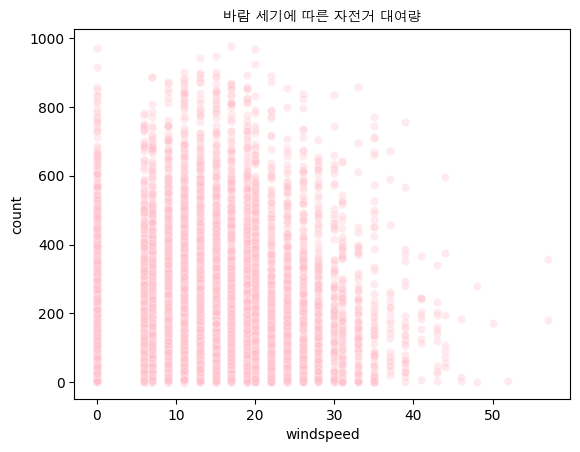

In [19]:
sns.scatterplot(x='windspeed', y='count', data=train_df, alpha=0.3, color='pink')   
plt.title("바람 세기에 따른 자전거 대여량", fontproperties=font_prop)
plt.show()

대신 바람의 세기를 나눠서 학습시키는 것이 나을 것 같다.   
이때 10 단위로 끊게 되면, 세밀하기 때문에 더욱 학습을 잘 할 수도 있지만 데이터의 뷸균형이 발생할 수 있을 것 같으므로   
➡️ ~20 / 20~30 / 30~ 세 구간으로 나눠서 학습시킬 것이다.

In [20]:
def label_wind(ws):
    if ws <= 20:
        return 'low'
    elif ws <= 30:
        return 'mid'
    else:
        return 'high'

train_df['wind_label'] = train_df['windspeed'].apply(label_wind)
test_df['wind_label'] = test_df['windspeed'].apply(label_wind)

encoder_wind = OneHotEncoder(sparse_output=False)
wind_ohe = encoder_wind.fit_transform(train_df[['wind_label']])
test_wind_ohe = encoder_wind.transform(test_df[['wind_label']])

wind_columns = encoder_wind.get_feature_names_out(['wind_label'])
train_wind_df = pd.DataFrame(wind_ohe, columns=wind_columns, index=train_df.index)
test_wind_df = pd.DataFrame(test_wind_ohe, columns=wind_columns, index=test_df.index)

train_df = pd.concat([train_df, train_wind_df], axis=1)
train_df.drop(['windspeed'], axis=1, inplace=True)
test_df = pd.concat([test_df, test_wind_df], axis=1)
test_df.drop(['windspeed'], axis=1, inplace=True)

In [21]:
train_df.head()

,season,holiday,workingday,weather,atemp,humidity,count,year,month,day,...,temp_label,temp_label_chill,temp_label_cold,temp_label_hot,temp_label_very hot,temp_label_warm,wind_label,wind_label_high,wind_label_low,wind_label_mid
0,1,0,0,1,14.395,81,16,2011,1,1,...,cold,0.0,1.0,0.0,0.0,0.0,low,0.0,1.0,0.0
1,1,0,0,1,13.635,80,40,2011,1,1,...,cold,0.0,1.0,0.0,0.0,0.0,low,0.0,1.0,0.0
2,1,0,0,1,13.635,80,32,2011,1,1,...,cold,0.0,1.0,0.0,0.0,0.0,low,0.0,1.0,0.0
3,1,0,0,1,14.395,75,13,2011,1,1,...,cold,0.0,1.0,0.0,0.0,0.0,low,0.0,1.0,0.0
4,1,0,0,1,14.395,75,1,2011,1,1,...,cold,0.0,1.0,0.0,0.0,0.0,low,0.0,1.0,0.0


### 📌 모델 구현

In [22]:
y_target = train_df['count']
X_features = train_df.drop(['count', 'temp_label', 'wind_label'], axis=1)

In [23]:
y_target_log = np.log1p(y_target)

In [24]:
categorical_cols = ['season', 'workingday', 'weather', 'year', 'month', 'day', 'hour', 'weekday']

X_features_ohe = pd.get_dummies(X_features, columns=categorical_cols)
X_test_submit = pd.get_dummies(test_df, columns=categorical_cols)
X_test_submit = X_test_submit.reindex(columns=X_features_ohe.columns, fill_value=0)

In [25]:
print("X_features_ohe shape: ", X_features_ohe.shape)
print("X_test_submit shape: ", X_test_submit.shape)
print("y_target_log shape: ", y_target_log.shape)

X_features_ohe shape:  (10886, 88)
X_test_submit shape:  (6493, 88)
y_target_log shape:  (10886,)


📍 평가함수

In [26]:
def rmsle(y, pred):
    return np.sqrt(np.mean((np.log1p(y) - np.log1p(pred)) ** 2))

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    print(f'RMSLE: {rmsle(y, pred):.3f}, RMSE: {rmse(y, pred):.3f}, MAE: {mean_absolute_error(y, pred):.3f}')

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X_features_ohe,
                                                      y_target_log, 
                                                      test_size=0.3, 
                                                      random_state=42)

models = {
    'Ridge': Ridge(alpha=10),
    'Lasso': Lasso(alpha=0.01),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=500, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=500, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_valid)
    pred = np.expm1(pred_log)
    y_valid_exp = np.expm1(y_valid)
    
    print(f'### {name} ###')
    evaluate_regr(y_valid_exp, pred)
    print()

### Ridge ###
RMSLE: 0.506, RMSE: 72.460, MAE: 46.839

### Lasso ###
RMSLE: 0.586, RMSE: 93.608, MAE: 60.636

### RandomForest ###
RMSLE: 0.314, RMSE: 42.386, MAE: 25.942

### GradientBoosting ###
RMSLE: 0.309, RMSE: 47.493, MAE: 29.090

### XGBoost ###
RMSLE: 0.313, RMSE: 43.219, MAE: 26.693

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 87
[LightGBM] [Info] Start training from score 4.585795
### LightGBM ###
RMSLE: 0.292, RMSE: 40.102, MAE: 24.379



In [28]:
def rmsle_cv(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

rmsle_scorer = make_scorer(rmsle_cv, greater_is_better=False)

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 500]
}

gs_lgbm = GridSearchCV(LGBMRegressor(random_state=42),
                       param_grid=param_grid,
                       scoring=rmsle_scorer,
                       cv=5, verbose=1)

gs_lgbm.fit(X_features_ohe, np.expm1(y_target_log))
print("LGBM Best Score (RMSLE):", -gs_lgbm.best_score_)
print("LGBM Best Params:", gs_lgbm.best_params_)

lgbm_model = gs_lgbm.best_estimator_
xgb_model = XGBRegressor(n_estimators=500, random_state=42)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 87
[LightGBM] [Info] Start training from score 214.846004
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 8709, number of used features: 87
[LightGBM] [Info] Start

In [29]:
print("XGBoost 교차검증 결과")
xgb_scores = cross_val_score(xgb_model, X_features_ohe, np.expm1(y_target_log),
                              scoring=rmsle_scorer, cv=5)
print("평균 RMSLE:", -xgb_scores.mean())
print("각 fold RMSLE:", -xgb_scores)

XGBoost 교차검증 결과
평균 RMSLE: 0.6635223659147202
각 fold RMSLE: [0.87751141 0.57056756 0.71544853 0.64101329 0.51307104]


In [30]:
lgbm_model.fit(X_features_ohe, y_target_log)
xgb_model.fit(X_features_ohe, y_target_log)

pred_lgbm_log = lgbm_model.predict(X_test_submit)
pred_xgb_log = xgb_model.predict(X_test_submit)

final_pred = (np.expm1(pred_lgbm_log) + np.expm1(pred_xgb_log)) / 2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 10886, number of used features: 87
[LightGBM] [Info] Start training from score 4.591364


In [31]:
# 제출 파일 생성
submission = pd.DataFrame({
    'datetime': datetime_col,
    'count': final_pred
})

submission.to_csv('submission_lgbm.csv', index=False)
print("저장 완료 submission_lgbm.csv")
submission.head()

저장 완료 submission_lgbm.csv


,datetime,count
0,2011-01-20 00:00:00,11.298369
1,2011-01-20 01:00:00,4.245720
2,2011-01-20 02:00:00,3.059402
3,2011-01-20 03:00:00,3.043737
4,2011-01-20 04:00:00,1.390264


Public Score: 0.38606